<a href="https://colab.research.google.com/github/SandhiyaAcharya/Emotion_Analysis/blob/main/Emotion_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

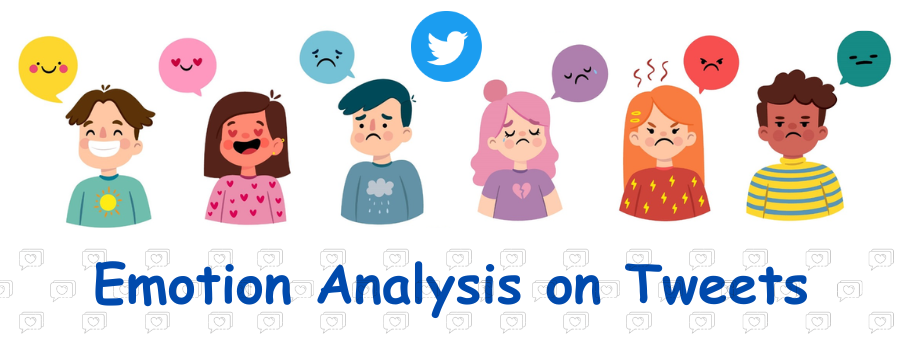

## Setting the Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install neattext
!pip install textblob
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.5 MB/s eta 0:00:00


## Import Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import neattext as nt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download("wordnet")
from textblob import TextBlob
import contractions
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D, Dense,Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import pad_sequences
import numpy as np
from keras.layers import LSTM, Flatten, BatchNormalization,Activation
from tensorflow.keras.layers import Dense, Dropout,InputLayer
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#Load dataset
data=pd.read_csv("/content/drive/MyDrive/Colab_Datasets/text_emotion.csv")
data.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [ ]:
data.shape

(40000, 4)

## Data Cleaning

In [ ]:
#Renaming the column name
data.rename(columns={"sentiment": "emotion"}, inplace=True)

In [ ]:
data.isnull().sum()

tweet_id    0
emotion     0
author      0
content     0
dtype: int64

In [ ]:
#Removing the empty string from “emotion” and eliminating zeros from the “content” .
data = data[data["emotion"].str.contains("empty") == False]
data = data[data["content"].str.contains("0") == False]

In [ ]:
data.head()

,tweet_id,emotion,author,content
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...


In [ ]:
(data['content']==0).sum()

0

In [ ]:
data['emotion'].unique()

array(['sadness', 'enthusiasm', 'neutral', 'worry', 'surprise', 'love',
       'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

[Text(0, 0, 'sadness'),
 Text(1, 0, 'enthusiasm'),
 Text(2, 0, 'neutral'),
 Text(3, 0, 'worry'),
 Text(4, 0, 'surprise'),
 Text(5, 0, 'love'),
 Text(6, 0, 'fun'),
 Text(7, 0, 'hate'),
 Text(8, 0, 'happiness'),
 Text(9, 0, 'boredom'),
 Text(10, 0, 'relief'),
 Text(11, 0, 'anger')]

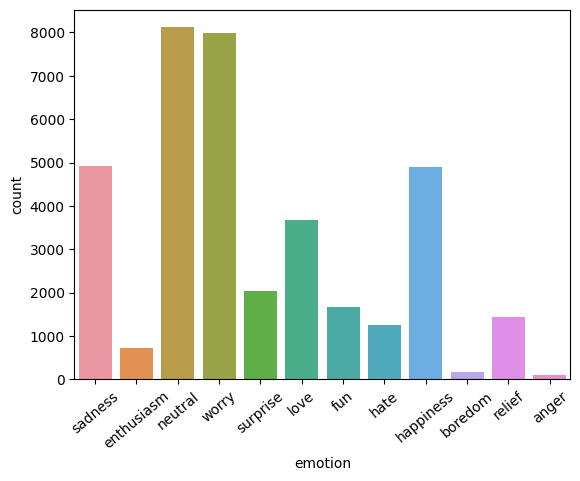

In [ ]:
emotions_count=sns.countplot(x='emotion',data=data)
emotions_count.set_xticklabels(emotions_count.get_xticklabels(), rotation=40)

## Text Processing

In [ ]:
data.head()

,tweet_id,emotion,author,content
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...


**Lowercasing-**  Convert all text to lowercase. This ensures uniformity and helps in reducing the dimensionality of the data.

In [ ]:
data['content']=data['content'].str.lower()
data.head()

,tweet_id,emotion,author,content
1,1956967666,sadness,wannamama,layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends soon!
4,1956968416,neutral,xkilljoyx,@dannycastillo we want to trade with someone w...
5,1956968477,worry,xxxPEACHESxxx,re-pinging @ghostridah14: why didn't you go to...


**Handling HTML Tags, emojis, emails and URLs-** If dealing with web data then remove HTML tags, URLS, emojis, emails.

In [ ]:
data['content'] = data['content'].apply(lambda text: nt.remove_html_tags(text))
data['content']= data['content'].apply(lambda text: nt.remove_urls(text))
data['content']= data['content'].apply(lambda text: nt.remove_emojis(text))
data['content']= data['content'].apply(lambda text: nt.remove_emails(text))


**Removing Special Characters and Numbers-** Remove any non-alphabetic characters and numbers. These often do not contribute to the semantics of the text.

In [ ]:
# Use regular expression to remove non-alphabetic characters and numbers
# def remove_special_chars_and_numbers(text):
#     cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
#     return cleaned_text
# data['content']=[remove_special_chars_and_numbers(text) for text in data['content']]
# data.head()

data['content']= data['content'].apply(lambda text: nt.remove_special_characters(text))
data['content']= data['content'].apply(lambda text: nt.remove_numbers(text))



**Handling Contractions-** Expand contractions (e.g., "can't" to "cannot")

In [ ]:
# vaex_data['content']= vaex_data['content'].apply(lambda text: nt.fix_contractions(text))
data['content']= data['content'].apply(lambda text:  contractions.fix(text))



**Removing Punctuation-** Remove all punctuation marks (e.g., periods, commas, exclamation marks) as they generally do not carry much information for many NLP tasks.



In [ ]:
# Using regular expression to remove punctuation
# def remove_punctuation(text):
#     cleaned_text = re.sub(r'[^\w\s]', '', text)
#     return cleaned_text
# data['content']=[remove_punctuation(text) for text in data['content']]
# data.head()

#Using NeatText
data['content']= data['content'].apply(lambda text: nt.remove_punctuations(text))

**Removing Stopwords-**  Remove common, low-information words (e.g., "and", "the", "in") known as stopwords.

In [ ]:
data['content']= data['content'].apply(lambda text: nt.remove_stopwords(text))

**Spell Checking-** Correct misspelled words using a spellchecker module.

In [ ]:
from textblob import TextBlob
data['content'] = data['content'].apply(lambda x: str(TextBlob(x).correct()))


**Removing Stopwords-**  Remove common, low-information words (e.g., "and", "the", "in") known as stopwords.

In [ ]:
data['content']= data['content'].apply(lambda text: nt.remove_stopwords(text))


**Tokenization-** Split the text into individual words or tokens. This makes it easier to analyze and process.

In [ ]:
data['content']= data['content'].apply(lambda text: word_tokenize(text))


**Lemmatization-** Reduce words to their base or root form. This helps in reducing the dimensionality of the feature space.

In [ ]:
lemmatizer = WordNetLemmatizer()
data['content'] = data['content'].apply(lambda text: [lemmatizer.lemmatize(word,pos='v') for word in text])

In [ ]:
data.to_csv('/content/drive/MyDrive/Colab_Datasets/clean_text.csv', index=False)

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/Colab_Datasets/clean_text.csv")

In [ ]:
label_encoder = preprocessing.LabelEncoder()

data['emotion']= label_encoder.fit_transform(data['emotion'])

data['emotion'].unique()

array([ 9,  2,  7, 11, 10,  6,  3,  5,  4,  1,  8,  0])

## Data Spliting
Splitting the data into training, validation, and testing sets.



The training set is the portion of the data used to train model.

The validation set is used during the training process to evaluate the model's performance and fine-tune hyperparameters. It helps in preventing overfitting. The validation set is not used for training.

The testing set is used after the model is trained to provide an unbiased evaluation of the final model's performance.

In [ ]:
X = data['content']
y = data['emotion']

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 70% training, 30% temp

# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% validation, 15% testing


In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((29599,), (29599,), (7400,), (7400,))

Checking the distribution of the data with resptect to emotion

In [ ]:
print("-----y train-----\n",y_train.value_counts())
print("-----y test-----\n",y_test.value_counts())

-----y train-----
 7     6419
11    6402
4     3953
9     3920
6     2978
10    1639
3     1340
8     1173
5      991
2      570
1      129
0       85
Name: emotion, dtype: int64
-----y test-----
 7     1701
11    1585
9     1006
4      948
6      701
10     405
3      330
8      266
5      253
2      148
1       37
0       20
Name: emotion, dtype: int64


## Preparing embedding layer

In [ ]:
word_tokenizer= Tokenizer()
word_tokenizer.fit_on_texts(X_train)
X_train= word_tokenizer.texts_to_sequences(X_train)
X_test= word_tokenizer.texts_to_sequences(X_test)

The input_dim parameter should be the size of your vocabulary, i.e. the set of all unique words present.

In [ ]:
vocab_length= len(word_tokenizer.word_index)+1
vocab_length

25113

Padding all reviews to fixed length 100

In [ ]:
maxlen= 100
X_train=pad_sequences(X_train, padding='post',maxlen=maxlen)
X_test=pad_sequences(X_test, padding='post',maxlen=maxlen)

Word Embedding

In [ ]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/Colab_Datasets/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(25113, 100)

## Model

### Convolutional Neural Network

 A basic deep learning model with an embedding layer followed by dense layers

In [ ]:
# Define the model
cnn_model = Sequential()

# Embedding Layer:
cnn_model.add(Embedding(input_dim=vocab_length, weights=[embedding_matrix], output_dim=100, input_length=maxlen))

# Convolutional Layers:
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())

# Dense Layers:
cnn_model.add(Dense(64, kernel_regularizer=l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))  # Adding Dropout with 50%
cnn_model.add(Dense(12, activation='softmax')) #12 emotions


In [ ]:
# Compile the model:
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(cnn_model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          2511300   
                                                                 
 conv1d_6 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_6 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_5 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 64)               

In [ ]:
# Model training
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2,callbacks=[early_stop])


Epoch 1/6
185/185 [==============================] - 39s 203ms/step - loss: 2.6620 - accuracy: 0.2140 - val_loss: 2.3865 - val_accuracy: 0.2199
Epoch 2/6
185/185 [==============================] - 43s 230ms/step - loss: 2.3310 - accuracy: 0.2147 - val_loss: 2.2893 - val_accuracy: 0.2199
Epoch 3/6
185/185 [==============================] - 36s 196ms/step - loss: 2.2592 - accuracy: 0.2139 - val_loss: 2.2324 - val_accuracy: 0.2199
Epoch 4/6
185/185 [==============================] - 37s 199ms/step - loss: 2.2112 - accuracy: 0.2148 - val_loss: 2.1931 - val_accuracy: 0.2199
Epoch 5/6
185/185 [==============================] - 38s 203ms/step - loss: 2.1780 - accuracy: 0.2161 - val_loss: 2.1658 - val_accuracy: 0.2098
Epoch 6/6
185/185 [==============================] - 38s 203ms/step - loss: 2.1551 - accuracy: 0.2179 - val_loss: 2.1472 - val_accuracy: 0.2098


In [ ]:
# Predictions on the Test Set

score=cnn_model.evaluate(X_test,y_test)

232/232 [==============================] - 2s 10ms/step - loss: 2.1383 - accuracy: 0.2142


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 2.2651100158691406
Test Accuracy: 0.22986486554145813


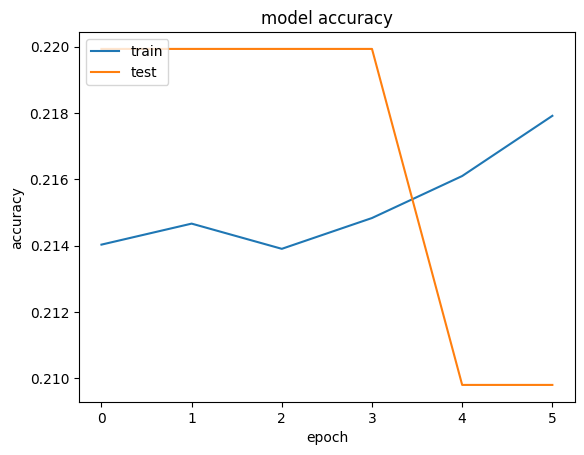

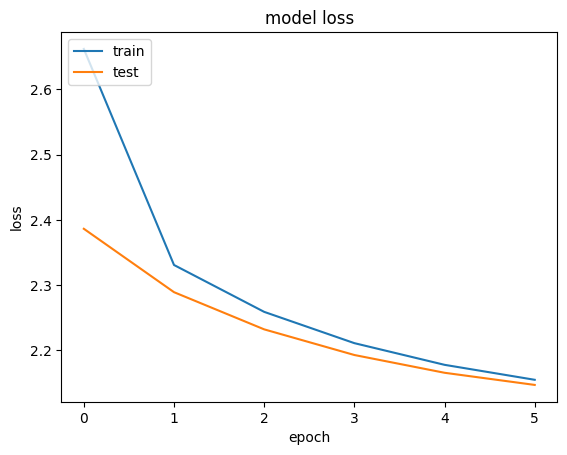

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['accuracy'])
plt.plot(cnn_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [ ]:
from keras.layers import LSTM

In [ ]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 100)          2511300   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2628677 (10.03 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 2511300 (9.58 MB)
_________________________________________________________________
None


In [ ]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
185/185 [==============================] - 85s 448ms/step - loss: -149.5992 - acc: 0.0043 - val_loss: -237.0467 - val_acc: 0.0046
Epoch 2/6
185/185 [==============================] - 81s 435ms/step - loss: -316.2686 - acc: 0.0043 - val_loss: -390.8653 - val_acc: 0.0046
Epoch 3/6
185/185 [==============================] - 85s 462ms/step - loss: -469.0655 - acc: 0.0043 - val_loss: -541.0975 - val_acc: 0.0046
Epoch 4/6
185/185 [==============================] - 81s 437ms/step - loss: -619.7251 - acc: 0.0043 - val_loss: -690.0471 - val_acc: 0.0046
Epoch 5/6
185/185 [==============================] - 81s 437ms/step - loss: -769.3949 - acc: 0.0043 - val_loss: -838.3834 - val_acc: 0.0046
Epoch 6/6
185/185 [==============================] - 80s 428ms/step - loss: -918.5438 - acc: 0.0043 - val_loss: -986.1866 - val_acc: 0.0046


In [ ]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

232/232 [==============================] - 17s 75ms/step - loss: -993.4935 - acc: 0.0050


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: -993.4934692382812
Test Accuracy: 0.004999999888241291


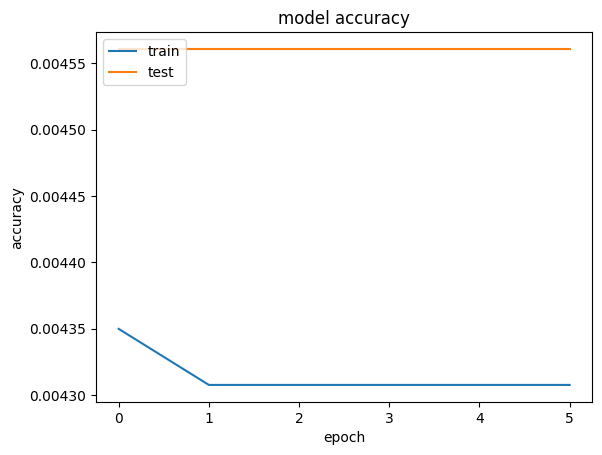

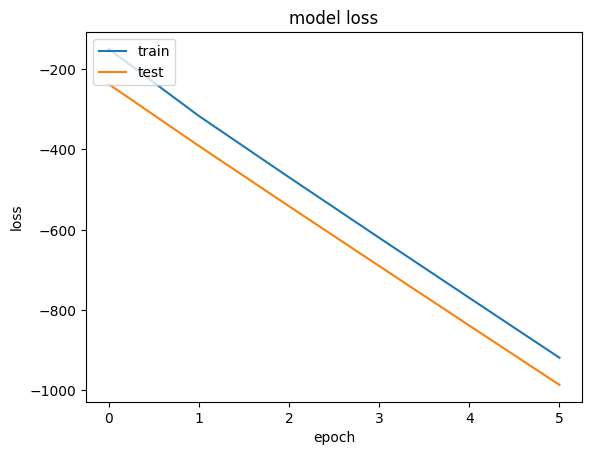

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()